# Marketing Analytics whith Google Cloud Platform 


We use a propensity to purchase system to predict customers who are most likely to make a purchase, so that we can personalize communications with them. We can use online predictions to take real-time action based on user behavior on our website, or batch predictions to inform less time-sensitive communications like email.


## Usecase: 
## Predicting customer propensity to buy in the next 30 days using BigQuery and AI Platform.

The marketeer of the ​Google Merchandise Store​ wants to effectively target visitors of its ecommerce website using paid search. For this reason the marketeer wants to know which visitors, that visited its website on a certain day, are more likely to convert (buy something) in the next 30 days.

The ecommerce store uses Google Analytics to track web visits on its ecommerce website. With the Google Analytics session data it has the availability of historical clickstream data of all its visitors, which includes previous visits, session duration, pageviews, device information, geographical information, transactions, etc. <br>

In this use case, we implement a machine learning workflow: <br> <br>
● Source the data from BigQuery <br>
● Explore and prepare the data <br>
● Code the models <br>
● Train, evaluate and tune the models <br>
● Select the best model <br>
● Deploy the best trained model <br>
● Get predictions from the model <br><br>



In [ ]:
! pip install imblearn
! pip install xgboost

In [245]:
import pandas as pd
import numpy as np 
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve, auc, fbeta_score, recall_score, precision_score,accuracy_score, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

import time

## Source data and data preparation

Google Analytics data of ​Google Merchandise Store​ is available as a public bigquery data set. For this use case we create the input features and the target variable using this data.

Bigquery dataset reference: bigquery-public-data:google_analytics_sample

### Dataset information
The dataset provides 12 months (August 2016 to August 2017) of obfuscated Google Analytics 360 data from the ​Google Merchandise Store​ , a real ecommerce store that sells Google-branded merchandise, in BigQuery. It’s a great way analyze business data 


The data is typical of what an ecommerce website would see and includes the following information: <br><br>
● Traffic source data: information about where website visitors originate, including data about organic traffic, paid search traffic, and display traffic. <br>
● Content data: information about the behavior of users on the site, such as URLs of pages that visitors look at, how they interact with content, etc.<br>
● Transactional data: information about the transactions on the Google Merchandise Store website. <br><br>

For more information see the ​Google Analytics Sample​ dataset description. <br>
https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset&q=google%20analytics%20sample&id=45f150ac-81d3-4796-9abf-d7a4f98eb4c6

# Reading the data from BigQuery
## Exploring Dataset

we explore a part of the dataset to get familiar with its columns and datatypes.


In [246]:
%%bigquery --project winged-tower-295515 firstday_df

SELECT *
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`

In [247]:
firstday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   visitorId             0 non-null      float64
 1   visitNumber           1711 non-null   int64  
 2   visitId               1711 non-null   int64  
 3   visitStartTime        1711 non-null   int64  
 4   date                  1711 non-null   object 
 5   totals                1711 non-null   object 
 6   trafficSource         1711 non-null   object 
 7   device                1711 non-null   object 
 8   geoNetwork            1711 non-null   object 
 9   customDimensions      1711 non-null   object 
 10  hits                  1711 non-null   object 
 11  fullVisitorId         1711 non-null   object 
 12  userId                0 non-null      object 
 13  channelGrouping       1711 non-null   object 
 14  socialEngagementType  1711 non-null   object 
dtypes: float64(1), int64(

In [248]:
firstday_df.head(3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,NaN,1,1470117657,1470117657,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 23, 'minu...",7194065619159478122,None,Social,Not Socially Engaged
1,NaN,151,1470083489,1470083489,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",8159312408158297118,None,Social,Not Socially Engaged
2,NaN,1,1470052694,1470052694,20160801,"{'visits': 1, 'hits': 4, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Southea...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 4, 'minut...",9236304747882138291,None,Social,Not Socially Engaged


## Creating Input Features

visitorId and userId are NAN, so we don't select them. There are some RECORDs in the dataset like: totals, trafficSource, device, geoNetwork, customDimensions, and hits. We explore their fields, their meaning,and their values, then we only select non-null fields that can be related to user purchase.

## Creating the output or target label

For defining the output label we need different columns. First, if a user has made a purchase on during his/her visit or not, which is shown by corresponding totals.transactions field. Then, we need fullVisitorId and visitStartTime to check if each customer has made a purchased in the next 30 days. To this end, we partition all the dataset based on fullVisitorId and order each partition based on visitStartTime in ascending way. Next, we consider a range of rows between current one and rows (visits) related to the next 30 days (30 days * 24 hours * 60 minutes * 60 seconds = 2592000). Then, we count the number of all purchases in that duration as total_purchases_next30days column. This column should be converted to a binary target label later.

Afterwards we can use fullVisitorId and date columns to validate the target label.


In [249]:
%%bigquery --project winged-tower-295515 sample_df

SELECT
  fullVisitorId, date, 
  visitStartTime, 
  visitNumber,
  IF(totals.transactions IS NULL, 0, 1) AS purchase,  
  
  COUNTIF(IF(totals.transactions IS NULL, FALSE, TRUE))
  OVER (
    PARTITION BY fullVisitorId 
    ORDER BY visitStartTime
    RANGE BETWEEN CURRENT ROW AND 2592000 FOLLOWING
  ) AS total_purchases_next30days,
  
  IFNULL(totals.bounces, 0) AS bounces,
  IFNULL(totals.hits, 0) AS hits,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(totals.timeOnSite, 0) AS time_on_site,
  IFNULL(totals.visits, 0) AS visits_interaction,

  device.isMobile AS is_mobile,
  trafficSource.isTrueDirect AS is_source_direct,
  IFNULL(geoNetwork.country, "") AS country,
  channelGrouping


FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20161001'

In [250]:
sample_df.head()

,fullVisitorId,date,visitStartTime,visitNumber,purchase,total_purchases_next30days,bounces,hits,pageviews,time_on_site,visits_interaction,is_mobile,is_source_direct,country,channelGrouping
0,0004880420457994269,20160825,1472169942,1,0,0,0,2,2,32,1,False,True,United States,Direct
1,0004880420457994269,20160914,1473887703,2,0,0,0,2,2,9,1,False,True,United States,Direct
2,0013232932172978597,20160902,1472839758,1,0,0,1,1,1,0,1,False,None,Turkey,Social
3,0032175980165826803,20160804,1470302496,1,0,0,0,2,2,35,1,False,None,Azerbaijan,Social
4,0036373064505192879,20160817,1471419836,1,0,0,1,1,1,0,1,False,None,United States,Social


# Data Preprocessing
Insert a new column for final binary label: whether a customer who visited the website on a certain day, convert (buy something) in the next 30 days or not.

In [251]:
label= sample_df['total_purchases_next30days']>0
sample_df.insert(7,'label',label)
sample_df.columns

Index(['fullVisitorId', 'date', 'visitStartTime', 'visitNumber', 'purchase',
       'total_purchases_next30days', 'bounces', 'label', 'hits', 'pageviews',
       'time_on_site', 'visits_interaction', 'is_mobile', 'is_source_direct',
       'country', 'channelGrouping'],
      dtype='object')

Find NAN values and the data type for each column.

In [252]:
summery_mat= pd.DataFrame()
summery_mat['NAN count']= sample_df.isnull().sum()

for col in sample_df.columns:
    summery_mat.loc[col,'type']= sample_df[col].dtype
summery_mat.T

,fullVisitorId,date,visitStartTime,visitNumber,purchase,total_purchases_next30days,bounces,label,hits,pageviews,time_on_site,visits_interaction,is_mobile,is_source_direct,country,channelGrouping
NAN count,0,0,0,0,0,0,0,0,0,0,0,0,0,104387,0,0
type,object,object,int64,int64,int64,int64,int64,bool,int64,int64,int64,int64,bool,object,object,object


Replace NAN values with False.

In [253]:
sample_df.is_source_direct.replace(to_replace= np.nan, value= False, inplace=True)
sample_df.is_source_direct.unique()

array([ True, False])

Convert categorical columns to dummies

In [254]:
sample_df.channelGrouping.unique()

array(['Direct', 'Social', 'Organic Search', 'Referral', 'Affiliates',
       'Paid Search', 'Display', '(Other)'], dtype=object)

In [255]:
sample_df['channelGrouping'].value_counts()

Social            50766
Organic Search    50382
Direct            21599
Referral          17380
Affiliates         3278
Paid Search        3103
Display             867
(Other)               5
Name: channelGrouping, dtype: int64

In [256]:
sample_df = pd.get_dummies(sample_df, columns=['channelGrouping'], prefix='channelGrouping_type')
sample_df.drop(columns=['channelGrouping_type_(Other)'], inplace=True)

# Highly Imbalanced Dataset?

In [257]:
class_count_0, class_count_1= sample_df.label.value_counts()
print("negative class: %d \t %.2f%% " %(class_count_0, round(class_count_0*100/len(sample_df), 2)))
print("positive class: %d \t %.2f%% "%(class_count_1, round(class_count_1*100/len(sample_df), 2)))

negative class: 143032 	 97.05% 
positive class: 4348 	 2.95% 


After preprocessing and cleansing, only 2.5% of all datapoints are from positive class. So, the class distribution is skewed, and the dataset is highly imbalanced. Classification of imbalanced datasets is one of the most challenging problems in the machine learning field. Because, it is hard for machine learning algorithms to learn a minority class with less than 1:10 ratio. Moreover, most of the standard and robust evaluation metrics like accuracy and F1-score become misleading and unreliable when classes are imbalanced. For instance, in our case, a no skill classifier that always predicts negative (majority) class, achieves roughly 97% accuracy while it predicts all positive datapoints incorrectly. So, the number of predicted true positives is zero, and consequently recall is zero too.

# Split the data to trainset and testset

We should split trainset and testset before balancing the trainset. It prevents information leakage.

We split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

We hold out 20% of the preprocessed dataset as the test set. It is important to use a stratified splitting method to maintain the real distribution of the positive class in the test set.

In [258]:
y= sample_df['label']
X= sample_df.drop(columns=['label','purchase','total_purchases_next30days','fullVisitorId','visitStartTime','date'], inplace=False)
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle= True, stratify= y)

# Make the trainset balanced: Undersampling its negative class

In [259]:
# UnderSampling
#from sklearn.utils import shuffle

Xy_trainVal_unblc = pd.concat([X_trainVal, y_trainVal], axis = 1) 
Xy_trainVal_unblc.reset_index(inplace=True, drop=True) 

pos_index = Xy_trainVal_unblc[Xy_trainVal_unblc['label']==1].index
positive_class= Xy_trainVal_unblc.iloc[pos_index].copy()
pos_len = len(positive_class)
#remove positives
Xy_trainVal_unblc.drop(pos_index, inplace=True)
neg_len = len(Xy_trainVal_unblc)

neg_coefficient = 1 

#Return a random sample of items from an axis of object.
negative_class = Xy_trainVal_unblc.sample(n= pos_len, replace='False', random_state = 42)#.reset_index(drop=True)
# balanced_df= pd.concat([positive_class, negative_class],ignore_index=True)

Xy_trainVal_blc= pd.concat([positive_class, negative_class],ignore_index=True)

# Just shuffling
Xy_trainVal_blc = shuffle(Xy_trainVal_blc,  random_state=42)
Xy_trainVal_blc = shuffle(Xy_trainVal_blc,  random_state=1)
Xy_trainVal_blc = shuffle(Xy_trainVal_blc,  random_state=5)
Xy_trainVal_blc = shuffle(Xy_trainVal_blc,  random_state=10)
Xy_trainVal_blc.reset_index(inplace=True, drop=True) 

# class_count_0, class_count_1= Xy_trainVal_blc.label.value_counts() #equal classs counts
# print( class_count_0, class_count_1)

y_trainVal_blc = Xy_trainVal_blc['label'].copy()
y_trainVal_blc = pd.DataFrame(y_trainVal_blc, columns=['label'])
X_trainVal_blc = Xy_trainVal_blc.drop(columns=['label'], inplace=False)

# X_trainVal_blc.head()

In [260]:
type(y_trainVal_blc)

pandas.core.frame.DataFrame

In [261]:
# rus = RandomUnderSampler(random_state=42)
# X_trainVal_rus, y_trainVal_rus = rus.fit_sample(X_trainVal, y_trainVal) # type: numpy.ndarray
# print('balanced X_trainVal shape',X_trainVal_rus.shape)

In [262]:
# # X_trainVal_rus type is numpy.ndarray. convert it to dataframe.
# columns_label = X_trainVal.columns
# X_trainVal_blc = pd.DataFrame(X_trainVal_rus, columns=columns_label)
# y_trainVal_blc = pd.DataFrame(y_trainVal_rus, columns=['label'])
# X_trainVal_blc.head()

# Convert categorical 'country' column to dummies
The majority of the countries have a few users who made a purchase. We just consider top 10% of countries -in the trainset- with the highest purchase counts and make dummy variables for them. The rest of countries are categorized as other.

Then we create the same dummy variables for the testset.

In [263]:
#list of all countries in the training set
all_countries_array= X_trainVal_blc['country'].unique()
all_countries = set(all_countries_array)
X_trainVal_blc['country'].value_counts()

United States     4642
India              152
Turkey             141
Canada             130
United Kingdom     118
                  ... 
Costa Rica           1
Senegal              1
Moldova              1
Cambodia             1
Laos                 1
Name: country, Length: 114, dtype: int64

In [264]:
# find the list of counrtries based on the number of users who have made a purchase in the next 30 days.
purchased_countries = X_trainVal_blc[y_trainVal_blc['label']==1]['country'].value_counts()
# purchased_countries is a seri type. we need its indices = countries' names 

# just top 10% countries: round(0.1*len(all_countries))
top_countries_series = purchased_countries.index[0:round(0.1*len(all_countries))]
top_countries = set(top_countries_series)

#replace other countries in trainset
other_countries_in_trainset = list(all_countries - top_countries)

X_trainVal_blc.replace(to_replace= other_countries_in_trainset, value='others', inplace=True)

#replace other countries in testset
all_countries_array= X_test['country'].unique()
all_countries_test = set(all_countries_array)
other_countries_in_testset = list(all_countries_test - top_countries)

X_test.replace(to_replace= other_countries_in_testset, value='others', inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Convert country columns to dummies in train and test

In [265]:
X_trainVal_blc = pd.get_dummies(X_trainVal_blc, columns=['country'], prefix='country_is')
X_trainVal_blc.drop(columns=['country_is_others'], inplace=True)

X_test = pd.get_dummies(X_test, columns=['country'], prefix='country_is')
X_test.drop(columns=['country_is_others'], inplace=True)

In [266]:
X_trainVal_blc.head()

,visitNumber,bounces,hits,pageviews,time_on_site,visits_interaction,is_mobile,is_source_direct,channelGrouping_type_Affiliates,channelGrouping_type_Direct,...,country_is_Canada,country_is_Chile,country_is_Hong Kong,country_is_Indonesia,country_is_Japan,country_is_Singapore,country_is_Taiwan,country_is_Thailand,country_is_United States,country_is_Venezuela
0,44,1,1,1,0,1,False,True,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,5,5,56,1,False,False,0,0,...,0,0,0,0,0,0,0,0,1,0
2,7,0,9,7,485,1,False,True,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,9,8,103,1,False,False,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,84,71,3550,1,False,True,0,0,...,0,0,0,0,0,0,0,0,1,0


In [267]:
# Converting boolean to integer 
X_trainVal_blc['is_mobile'] = list(map(int, X_trainVal_blc['is_mobile'])) 
X_trainVal_blc['is_source_direct'] = list(map(int, X_trainVal_blc['is_source_direct'])) 
X_trainVal_blc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   visitNumber                          6956 non-null   int64
 1   bounces                              6956 non-null   int64
 2   hits                                 6956 non-null   int64
 3   pageviews                            6956 non-null   int64
 4   time_on_site                         6956 non-null   int64
 5   visits_interaction                   6956 non-null   int64
 6   is_mobile                            6956 non-null   int64
 7   is_source_direct                     6956 non-null   int64
 8   channelGrouping_type_Affiliates      6956 non-null   uint8
 9   channelGrouping_type_Direct          6956 non-null   uint8
 10  channelGrouping_type_Display         6956 non-null   uint8
 11  channelGrouping_type_Organic Search  6956 non-null   uin

# Pearson correlation matrix heatmap for the data set
We have a data set with many columns, a good way to quickly check correlations among columns is by visualizing the correlation matrix as a heatmap.

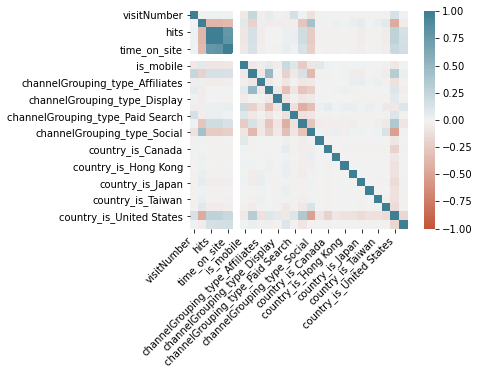

In [268]:
corr = X_trainVal_blc.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200,),#annot=True, #for showing numbers on the heatmap
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

We plot the Pearson correlation heatmap and see the correlation of features. In the above heatmap blue means positive, red means negative. The stronger the color, the larger the correlation magnitude.

The correlation coefficient has values between -1 to 1

- A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
- A value closer to 1 implies stronger positive correlation
- A value closer to -1 implies stronger negative correlation
One of the assumptions of logistic regression is that the independent variables need to be uncorrelated with each other. (If these variables are correlated with each other, then we need to keep only one of them and drop the rest.) Therefore, we don't train a logistic regression for this classification problem.

# Machine Learning Models

We build a model that predicts which visitors, that visited its website on a certain day, are more likely to convert (buy something) in the next 30 days.
We use the AI Notebook service of the Google Cloud Platform to develop the model. <br> <br> <br>

convert train and test labels to int.

In [269]:
y_trainVal_blc = y_trainVal_blc.astype('int')
y_test = y_test.astype('int')


# Evaluation Metrics
Given that there are many various evaluation metrics, selecting the correct metric for a problem is a crucial issue. It depends on the dataset, models, nature of problem and what is important for project stakeholders. Here we discuss what evaluation metrics should be used for imbalanced data.

## Threshold Metrics

threshold metrics like accuracy and F-measure are easy to understand, calculate and interpret. However, their important disadvantage is that they assume the class imbalance observed in the training set is the same as class distribution in the test set and in the real data where the model will be deployed to make predictions. Hence, if the class imbalance in thereal-world data is different from the training set, these metrics can be misleading (Brownlee, 2020)

## Ranking Metrics

Ranking metrics like ROC-AUC and Precision-Recall AUC.

ROC AUC cares equally about positive and negative classes. So, it is an appropriate metric for balanced datasets where we care about true negatives as much as we care about true positives. Consequently, we should not use it when the dataset is imbalanced (Neptune.ai, 2019)

PR AUC = Precision-Recall Area Under Curve (average precision)

Like the ROC AUC, the area under the Precision-Recall curve can be calculated as a score and then be used to compare classifiers. Precision-Recall AUC focuses on the minority class which makes it suitable for imbalanced classification problems (Brownlee, 2020).

Selecting Evaluation Metrics

Considering our goal, we don’t want to miss out on a customer who will potentially convert. In other words, misclassifying a potential visitor is more expensive and undesirable for us while we may not suffer much losses if a model misclassifies a visitor that will not convert. Hence, we utilize evaluation metrics appropriate not only for imbalance datasets but also for focusing on decreasing false negatives cases (reducing misclassified potential visitors who will convert). Our main evaluation metrics are PR AUC and recall; besides that we consider accuracy and F2-score too.

# RANDOM FOREST
a forest of randomly created decision trees. Each node in the decision tree works on a random subset of features to calculate the output. The random forest then combines the output of individual decision trees to generate the final output. Random forest leverages the power of multiple decision trees. It does not rely on the feature importance given by a single decision tree.

RandomForests: The algorithm builds randomized trees on random samples of the data. It reduces overfitting by averaging out individual predictions (variance reduction)

Repeat n_estimators times -> Higher values: more trees, more smoothing.
Randomize trees by considering only a random subset of features of size max_features in each node --> Small max_features yields more different trees, more smoothing .
## Train

- We use grid search for hyperparameter tuning.

- We apply 5-fold cross validation for spliting training set and vaidation set.

- We calculate different evalution metrics like average precision AUC, ROC AUC, recall, precision, and accuracy.

In [270]:
param_grid = {'n_estimators':[1500, 1000], 'criterion': ['gini','entropy'], 'min_samples_leaf':[100, 50,10],
              'min_samples_split': [200,100], 'max_features':['sqrt'],
              'class_weight':['balanced'], 'random_state':[0], 'bootstrap':[True], 'oob_score':[True]}

# If bootstrap is True, the number of samples to draw from X to train each base estimator.
# If None (default), then draw X.shape[0] samples.

# oob_score: Whether to use out-of-bag samples to estimate the generalization accuracy.

cv_scoring = {'average_precision_PR_AUC':'average_precision', 'AUC': 'roc_auc','recall':'recall', 'precision':'precision','accuracy':'accuracy'}


grid = GridSearchCV(RandomForestClassifier(), param_grid= param_grid, cv=5, scoring= cv_scoring, 
                    refit='average_precision_PR_AUC', return_train_score=True, n_jobs= -1, verbose=1)

grid_result = grid.fit(X_trainVal_blc, y_trainVal_blc)
                         

print("RandomForestClassifier :\n{}".format( grid.best_estimator_))
print("RandomForestClassifier best_params_:\n{}".format( grid.best_params_))

grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.1min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomForestClassifier :
RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=100,
                       n_estimators=1000, oob_score=True, random_state=0)
RandomForestClassifier best_params_:
{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 1000, 'oob_score': True, 'random_state': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,...,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy
0,8.572158,0.078810,0.891948,0.018945,True,balanced,gini,sqrt,100,200,...,0.855665,0.003033,23,0.860532,0.857323,0.855166,0.860018,0.859479,0.858504,0.001995
1,5.614890,0.037261,0.603909,0.013266,True,balanced,gini,sqrt,100,200,...,0.855952,0.002795,19,0.861431,0.857143,0.855705,0.860198,0.859659,0.858827,0.002094
2,8.348026,0.040453,0.876690,0.022460,True,balanced,gini,sqrt,100,100,...,0.855665,0.003033,23,0.860532,0.857323,0.855166,0.860018,0.859479,0.858504,0.001995
3,5.562114,0.028758,0.603357,0.010025,True,balanced,gini,sqrt,100,100,...,0.855952,0.002795,19,0.861431,0.857143,0.855705,0.860198,0.859659,0.858827,0.002094
4,8.635044,0.089709,0.931522,0.025834,True,balanced,gini,sqrt,50,200,...,0.866016,0.003210,14,0.874371,0.867026,0.866846,0.871518,0.869003,0.869753,0.002860


Test the model

We trained random forests with different grid parameters and evaluate them on the validation set. Then, the model with the best performance is chosen. We retrain the best model on the whole training set and finally test it on the test set.

In [271]:
rf_refit = grid.best_estimator_.fit(X_trainVal_blc,y_trainVal_blc)
y_pred= rf_refit.predict(X_test)
y_probabilities = rf_refit.predict_proba(X_test)[:,1] # for average_precision_score (PR AUC)

print('f beta=1 score',fbeta_score(y_test, y_pred, beta=1))
print('f beta=2 score',fbeta_score(y_test, y_pred, beta=2))
print('confusion_matrix: tn, fp, fn, tp',confusion_matrix(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('accuracy_score',accuracy_score(y_test, y_pred))

# Average Precision is a single number used to summarise a Precision-Recall curve:
# average_precision_score function expect confidence or probability as second parameter.
# Target scores, can either be probability estimates of the positive class

print('\n average_precision_score (PR AUC)',average_precision_score(y_test, y_probabilities))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


f beta=1 score 0.25882728870426586
f beta=2 score 0.4566467470966287
confusion_matrix: tn, fp, fn, tp [[24027  4579]
 [   60   810]]
recall_score 0.9310344827586207
precision_score 0.150306179254036
accuracy_score 0.8426177228932012

 average_precision_score (PR AUC) 0.39313387895930835


## Feature Importance

A popular feature of random forest is providing the feature importance. Furthermore, random forests are easy to apply because they require little feature preprocessing and parameter tuning.

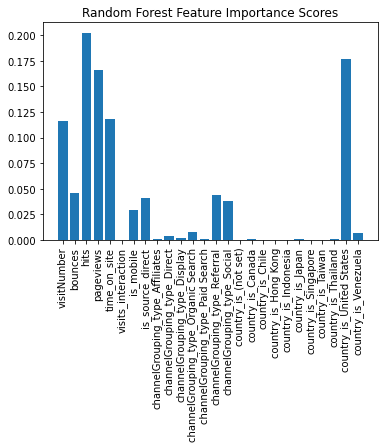

In [272]:
importance = rf_refit.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(X_test.columns, importance)
plt.xticks( rotation='vertical')
plt.title("Random Forest Feature Importance Scores")
plt.savefig("Random Forest Feature Importance Scores",bbox_inches='tight')
plt.show()

# XGBoost
Gradient boosting machine creates a prediction model in the form of an ensemble of weak decision trees. It trains many decision trees in an additive and sequential way, giving higher weights to the points misclassified by previous trees. In other words, it trains a model, then uses its prediction outcome to increase the weights of datapoints that were badly predicted and decrease the weights of correctly predicted datapoints. Next, it adopts the updated data for training the next decision tree (Singh, 2018).

We apply XGBoost for implementing gradient boosting machines which is an efficient and effective library. It uses approximation methods to make it faster than scikit-learnGradientBoostingClassifier. XGBoost has some important parameters. n_estimators is the number of trees it will train. The higher the estimators, the better although, it might start to overfit. To avoid overfitting, we should set a small value to max_depth parameter to apply strong pre-pruning and create very shallow trees. Moreover, XGBoost has a learning rate parameter that controls how strongly the weights are updated in each iteration. Lower rates mean more trees are required to build more complex models.

We implement and compare different Gradient boosting machines by using grid search and 5-fold cross validation.

In [275]:
param_grid = {'max_depth': [3], 'n_estimators': [1200], 'learning_rate': [ 0.01, 0.1],
              'gamma': [ 1],'min_child_weight': [1], 'subsample': [0.6,0.8],
              'colsample_bytree': [0.6],'random_state':[0]}
              


cv_scoring = {'average_precision_PR_AUC':'average_precision', 'AUC': 'roc_auc','recall':'recall', 'precision':'precision','accuracy':'accuracy'}

xgb = XGBClassifier(objective= 'binary:logistic',seed=0)
#     nthread=4, silent=True


grid_x = GridSearchCV(xgb, param_grid= param_grid, cv=5, scoring= cv_scoring, 
                    refit='average_precision_PR_AUC', return_train_score=True, n_jobs= -1, verbose=1)

grid_result = grid_x.fit(X_trainVal_blc, y_trainVal_blc)
                         
print("XGBClassifier :\n{}".format( grid_x.best_estimator_))
print("XGBClassifier best_params_:\n{}".format( grid_x.best_params_))

grid_x_df = pd.DataFrame(grid_x.cv_results_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[09:44:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier :
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
XGBClassifier best_params_:
{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_e

The training procedure is the same as in the previous models. We trained the gradient boosting model with different grid parameters and evaluated them on the validation set. Then, the model with the best performance is chosen. We retrain the best model on the whole training set and finally test it on the test set.

In [276]:
xgb_refit = grid_x.best_estimator_.fit(X_trainVal_blc,y_trainVal_blc)
y_pred= xgb_refit.predict(X_test)
y_probabilities = xgb_refit.predict_proba(X_test)[:,1] # for average_precision_score


print('f beta=1 score',fbeta_score(y_test, y_pred, beta=1))
print('f beta=2 score',fbeta_score(y_test, y_pred, beta=2))
print('confusion_matrix: tn, fp, fn, tp',confusion_matrix(y_test, y_pred))
print('recall_score',recall_score(y_test, y_pred))
print('precision_score',precision_score(y_test, y_pred))
print('accuracy_score',accuracy_score(y_test, y_pred))

# Average Precision is a single number used to summarise a Precision-Recall curve:
# average_precision_score function expect confidence or probability as second parameter.
# Target scores, can either be probability estimates of the positive class

print('\n average_precision_score (PR AUC)',average_precision_score(y_test, y_probabilities))

[10:08:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f beta=1 score 0.2632606573381061
f beta=2 score 0.46196893558702606
confusion_matrix: tn, fp, fn, tp [[24139  4467]
 [   61   809]]
recall_score 0.9298850574712644
precision_score 0.15333586050037906
accuracy_score 0.8463834984394083

 average_precision_score (PR AUC) 0.3657907900976537


## Feature Importance

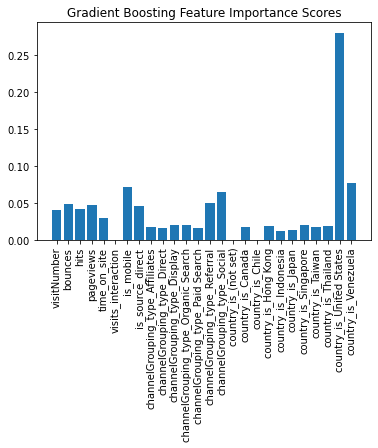

In [277]:
# get importance
importance = xgb_refit.feature_importances_

plt.bar(X_test.columns, importance)
plt.xticks( rotation='vertical')
plt.title("Gradient Boosting Feature Importance Scores")
plt.savefig("Gradient Boosting Feature Importance Scores",bbox_inches='tight')
plt.show()

# Batch prediction
read the last day of data as a batch

In [279]:
%%bigquery --project winged-tower-295515 batch_df

SELECT
  fullVisitorId, date, 
  visitStartTime, 
  visitNumber,
  IF(totals.transactions IS NULL, 0, 1) AS purchase,  
  
  COUNTIF(IF(totals.transactions IS NULL, FALSE, TRUE))
  OVER (
    PARTITION BY fullVisitorId 
    ORDER BY visitStartTime
    RANGE BETWEEN CURRENT ROW AND 2592000 FOLLOWING
  ) AS total_purchases_next30days,
  
  IFNULL(totals.bounces, 0) AS bounces,
  IFNULL(totals.hits, 0) AS hits,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(totals.timeOnSite, 0) AS time_on_site,
  IFNULL(totals.visits, 0) AS visits_interaction,

  device.isMobile AS is_mobile,
  trafficSource.isTrueDirect AS is_source_direct,
  IFNULL(geoNetwork.country, "") AS country,
  channelGrouping


FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`

In [280]:
batch_df.shape

(2556, 15)

# Preprocess Batch Data

In [281]:
label= batch_df['total_purchases_next30days']>0
batch_df.insert(7,'label',label)

# Replace NAN values with False
batch_df.is_source_direct.replace(to_replace= np.nan, value= False, inplace=True)
batch_df.is_source_direct.unique()

array([False,  True])

In [282]:
#Convert categorical columns to dummies
batch_df = pd.get_dummies(batch_df, columns=['channelGrouping'], prefix='channelGrouping_type')
# batch_df.drop(columns=['channelGrouping_type_(Other)'], inplace=True)

In [283]:
y_batch= batch_df['label']
y_batch = y_batch.astype('int')

X_batch= batch_df.drop(columns=['label','purchase','total_purchases_next30days','fullVisitorId','visitStartTime','date'], inplace=False)

In [284]:
#Convert categorical 'country' column to dummies
all_countries_array= X_batch['country'].unique()
all_countries_test = set(all_countries_array)
other_countries_in_testset = list(all_countries_test - top_countries)

X_batch.replace(to_replace= other_countries_in_testset, value='others', inplace=True)

X_batch = pd.get_dummies(X_batch, columns=['country'], prefix='country_is')
X_batch.drop(columns=['country_is_others'], inplace=True)

In [285]:
X_batch.shape

(2556, 26)